In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import  MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from pandas.tseries.offsets import CustomBusinessMonthBegin

In [2]:
df = pd.read_csv('sp500_Adjclose.csv')

df['Date'] = pd.to_datetime(df.Date)

df.set_index('Date', inplace=True)


In [3]:
ticker = input('> What is the ticker for the company'
               ' whose adjusted close value you want to predict for? \n>').upper()

df = df.loc[:,[f'{ticker}']]

df = df.resample('MS').mean()

> What is the ticker for the company whose adjusted close value you want to predict for? 
>mmm


In [4]:
len(df)

test_size = int(input(">What is your test set size in months? \nIdeally less than 24 months \n"))

len(df)- test_size

>What is your test set size in months? 
Ideally less than 24 months 
18


224

In [5]:
test_ind = len(df)- test_size

In [6]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [7]:
train

,MMM
Date,
2000-01-01,26.994161
2000-02-01,24.795302
2000-03-01,24.288003
2000-04-01,25.987985
2000-05-01,24.487872
...,...
2018-04-01,199.112898
2018-05-01,188.358998
2018-06-01,189.831294


In [8]:
test

,MMM
Date,
2018-09-01,201.264673
2018-10-01,190.910536
2018-11-01,191.170284
2018-12-01,186.176839
2019-01-01,184.784626
2019-02-01,197.726914
2019-03-01,199.081088
2019-04-01,203.466542
2019-05-01,166.782777


In [9]:
scaler = MinMaxScaler()

In [10]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [11]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [13]:
X,y = generator[0]

In [14]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.01413175 0.00341863 0.000947   0.00922953 0.00192079 0.
 0.00541476 0.01391027 0.00766245 0.01263887 0.0194618  0.04550258]
Predict this y: 
 [[0.04239666]]


In [15]:
n_features = 1

In [16]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [18]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [19]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [20]:
model.fit_generator(generator,epochs=14,
                    validation_data=validation_generator)

Epoch 1/14
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
212/212 [==============================] - 4s 21ms/step - loss: 0.0089 - val_loss: 0.0302
Epoch 2/14
212/212 [==============================] - 2s 11ms/step - loss: 0.0028 - val_loss: 0.0059
Epoch 3/14
212/212 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0148
Epoch 4/14
212/212 [==============================] - 2s 11ms/step - loss: 0.0025 - val_loss: 0.0060
Epoch 5/14
212/212 [==============================] - 2s 11ms/step - loss: 0.0024 - val_loss: 0.0141
Epoch 6/14
212/212 [==============================] - 2s 11ms/step - loss: 0.0020 - val_loss: 0.0086
Epoch 7/14
212/212 [==============================] - 3s 12ms/step - loss: 0.0013 - val_loss: 0.0141
Epoch 8/14
212/212 [==============================] - 2s 11ms/step - loss: 0.0015 - val_loss: 0.0054
Epoch 9/14
212/212 [==============================] - 2s 11ms/step - loss: 0.0014 - val_loss: 0.00

In [21]:
losses = pd.DataFrame(model.history.history)

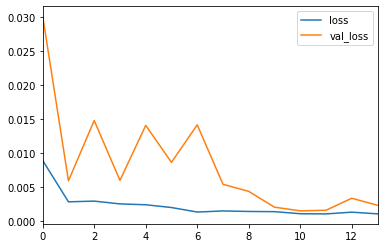

In [22]:
losses.plot()

In [23]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    

In [24]:
true_predictions = scaler.inverse_transform(test_predictions)

In [25]:
test['Predictions'] = true_predictions

C:\Users\khatt\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
test

,MMM,Predictions
Date,,
2018-09-01,201.264673,196.603418
2018-10-01,190.910536,198.142308
2018-11-01,191.170284,200.113846
2018-12-01,186.176839,202.173272
2019-01-01,184.784626,204.311202
2019-02-01,197.726914,206.604722
2019-03-01,199.081088,208.877102
2019-04-01,203.466542,211.156345
2019-05-01,166.782777,213.342440


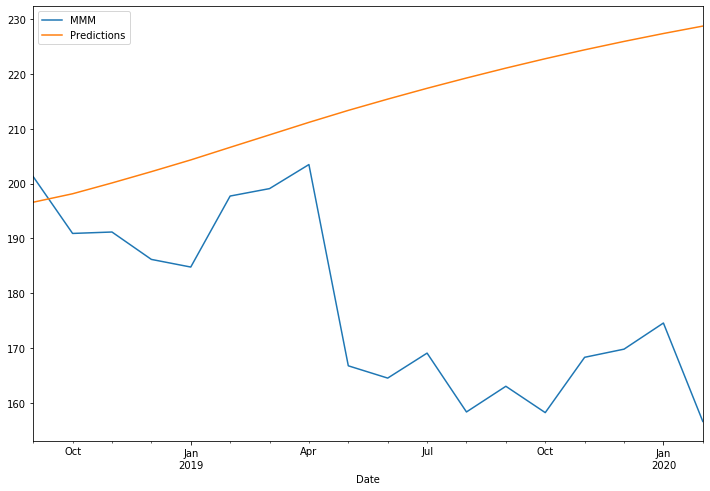

In [27]:
test.plot(figsize=(12,8))

In [28]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [29]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [30]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=20)

Epoch 1/20
230/230 [==============================] - 4s 18ms/step - loss: 0.0203
Epoch 2/20
230/230 [==============================] - 3s 12ms/step - loss: 0.0039
Epoch 3/20
230/230 [==============================] - 3s 12ms/step - loss: 0.0025
Epoch 4/20
230/230 [==============================] - 3s 12ms/step - loss: 0.0023
Epoch 5/20
230/230 [==============================] - 3s 12ms/step - loss: 0.0023
Epoch 6/20
230/230 [==============================] - 3s 11ms/step - loss: 0.0022
Epoch 7/20
230/230 [==============================] - 2s 11ms/step - loss: 0.0021
Epoch 8/20
230/230 [==============================] - 3s 12ms/step - loss: 0.0017
Epoch 9/20
230/230 [==============================] - 3s 11ms/step - loss: 0.0018
Epoch 10/20
230/230 [==============================] - 3s 12ms/step - loss: 0.0017
Epoch 11/20
230/230 [==============================] - 3s 12ms/step - loss: 0.0017
Epoch 12/20
230/230 [==============================] - 3s 12ms/step - loss: 0.0016
Epoch 13/20
2

In [31]:
forecast = []

In [32]:
periods = 12

In [33]:
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

In [34]:
for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    
    forecast.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    

In [35]:
forecast = scaler.inverse_transform(forecast)

In [36]:
df

,MMM
Date,
2000-01-01,26.994161
2000-02-01,24.795302
2000-03-01,24.288003
2000-04-01,25.987985
2000-05-01,24.487872
...,...
2019-10-01,158.249711
2019-11-01,168.334397
2019-12-01,169.818376


In [37]:
forecast_index = pd.date_range(start='2020-03-01',periods=periods,freq='MS')

In [38]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [39]:
forecast_df

,Forecast
2020-03-01,167.370588
2020-04-01,168.434281
2020-05-01,169.625902
2020-06-01,170.893446
2020-07-01,172.391622
2020-08-01,174.039026
2020-09-01,175.438658
2020-10-01,176.828308
2020-11-01,178.165267
2020-12-01,179.489356


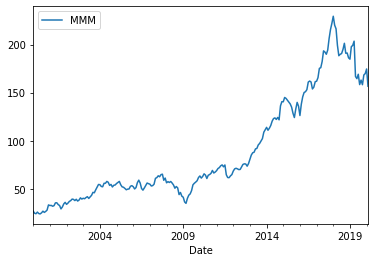

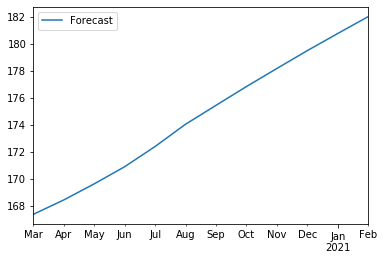

In [40]:
df.plot()
forecast_df.plot()

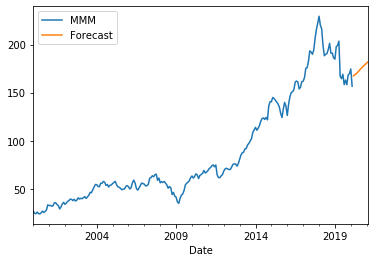

In [41]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576, 623)

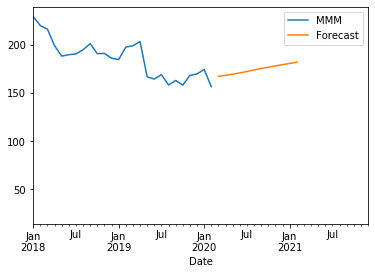

In [42]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2021-12-01')